# CIFAR-10 Double Descent Experiments

**GRA4157 Big Data - Final Project**

Jakob Sverre Alexandersen

This notebook runs comprehensive double descent experiments on CIFAR-10:
1. **Model-wise Double Descent**: Training models of varying complexity
2. **Epoch-wise Double Descent**: Training a single model for many epochs


In [1]:
# Global seed for reproducibility
SEED = 42

# Experiment configuration
CONFIG = {
    'seed': SEED,
    'model_wise': {
        'num_epochs': 100,
        'learning_rate': 0.001,
        'results_dir': 'results/model_wise'
    },
    'epoch_wise': {
        'model_name': 'Baseline', 
        # 'model_name': 'Medium',
        'num_epochs': 30_000,
        'learning_rate': 0.001,
        'results_dir': 'results/epoch_wise'
    }
}

print(f"Configuration loaded with seed: {SEED}")
print(f"Model-wise: {CONFIG['model_wise']['num_epochs']} epochs")
print(f"Epoch-wise: {CONFIG['epoch_wise']['num_epochs']} epochs")


Configuration loaded with seed: 42
Model-wise: 100 epochs
Epoch-wise: 30000 epochs


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.manifold import TSNE

# Import experiment functions
from cifar10_experiments import (
    load_cifar10,
    get_class_names,
    run_model_wise_experiment,
    run_epoch_wise_experiment,
    plot_model_wise_double_descent,
    plot_epoch_wise_double_descent,
    plot_confusion_matrix,
    create_results_summary_table
)

# Set random seeds for all libraries
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif torch.backends.mps.is_available():
    print("Using MPS")
else:
    print("Using CPU")


Using device: mps
Using MPS


## Dataset Exploration

Before running double descent experiments, we first explore the CIFAR-10 dataset to understand its size, class balance, and some example images.


In [4]:
print("="*80)
print("loading cifar-10 dataset")
print("="*80)
print(f"start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

X_train, X_val, X_test, y_train, y_val, y_test = load_cifar10(seed=SEED)
class_names = get_class_names()

print(f"\nclass names: {class_names}")


loading cifar-10 dataset
start time: 2025-11-30 18:40:04
train set: 35000 samples
validation set: 15000 samples
test set: 10000 samples
classes: 10

class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# Basic dataset statistics and image tensors

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]
num_features = X_train.shape[1]

print(f"Train set: {num_train} samples")
print(f"Validation set: {num_val} samples")
print(f"Test set: {num_test} samples")
print(f"Input dimensionality: {num_features} = 3 * 32 * 32")

# Reshape flattened vectors back into image tensors for visualization: (N, C, H, W)
X_train_img = X_train.reshape(-1, 3, 32, 32)
X_val_img = X_val.reshape(-1, 3, 32, 32)
X_test_img = X_test.reshape(-1, 3, 32, 32)

print(f"Train images tensor shape: {X_train_img.shape}")
print(f"Validation images tensor shape: {X_val_img.shape}")
print(f"Test images tensor shape: {X_test_img.shape}")

# Per-channel pixel statistics in the normalized space
channel_names = ['R', 'G', 'B']
train_channel_means_norm = X_train_img.mean(axis=(0, 2, 3))
train_channel_stds_norm = X_train_img.std(axis=(0, 2, 3))

print("\nPer-channel statistics (normalized space, train split):")
for ch, m, s in zip(channel_names, train_channel_means_norm, train_channel_stds_norm):
    print(f"  {ch}: mean={m:.3f}, std={s:.3f}")

print(f"\nNormalized pixel range (train): min={X_train_img.min():.2f}, max={X_train_img.max():.2f}")



Train set: 35000 samples
Validation set: 15000 samples
Test set: 10000 samples
Input dimensionality: 3072 = 3 * 32 * 32
Train images tensor shape: (35000, 3, 32, 32)
Validation images tensor shape: (15000, 3, 32, 32)
Test images tensor shape: (10000, 3, 32, 32)

Per-channel statistics (normalized space, train split):
  R: mean=0.001, std=0.999
  G: mean=0.001, std=1.000
  B: mean=0.001, std=1.000

Normalized pixel range (train): min=-1.99, max=2.13


Class counts (train / val / test / total):
 0 - airplane  :   3500 /   1500 /   1000 /   6000
 1 - automobile:   3500 /   1500 /   1000 /   6000
 2 - bird      :   3500 /   1500 /   1000 /   6000
 3 - cat       :   3500 /   1500 /   1000 /   6000
 4 - deer      :   3500 /   1500 /   1000 /   6000
 5 - dog       :   3500 /   1500 /   1000 /   6000
 6 - frog      :   3500 /   1500 /   1000 /   6000
 7 - horse     :   3500 /   1500 /   1000 /   6000
 8 - ship      :   3500 /   1500 /   1000 /   6000
 9 - truck     :   3500 /   1500 /   1000 /   6000


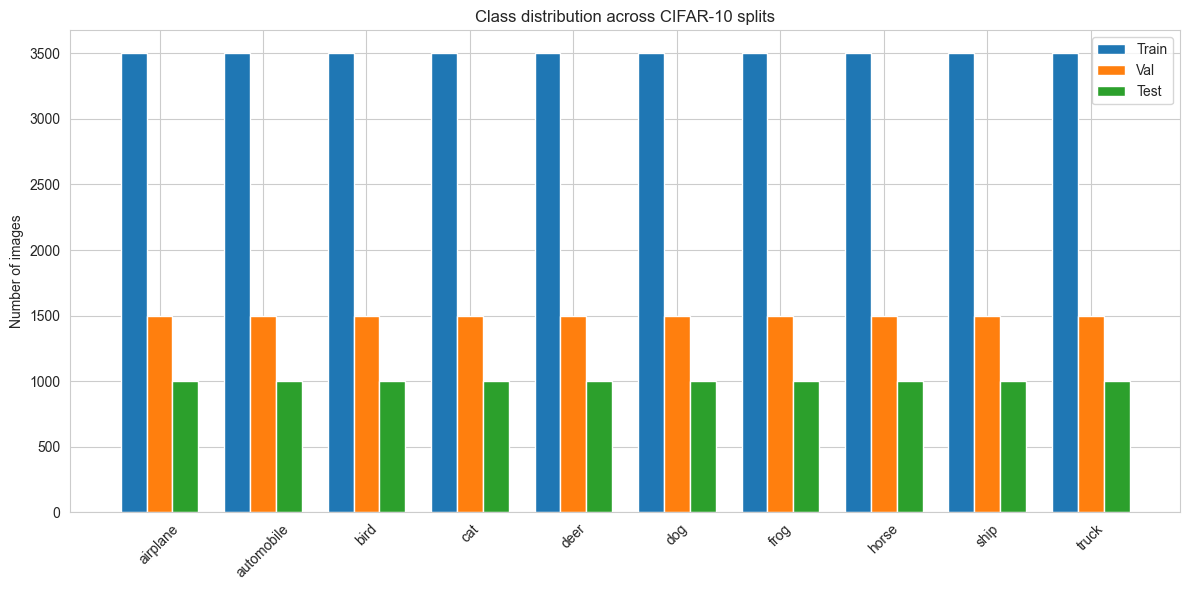

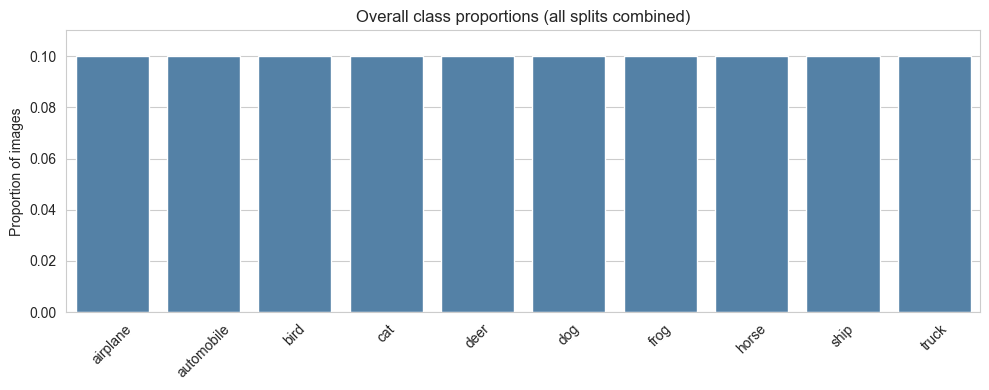

In [6]:
# Class balance across train / validation / test splits

num_classes = len(class_names)

train_counts = np.bincount(y_train, minlength=num_classes)
val_counts = np.bincount(y_val, minlength=num_classes)
test_counts = np.bincount(y_test, minlength=num_classes)

total_counts = train_counts + val_counts + test_counts

print("Class counts (train / val / test / total):")
for idx, name in enumerate(class_names):
    print(
        f"{idx:2d} - {name:10s}: "
        f"{train_counts[idx]:6d} / {val_counts[idx]:6d} / {test_counts[idx]:6d} / {total_counts[idx]:6d}"
    )

# Plot class distribution for each split
indices = np.arange(num_classes)
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(indices - width, train_counts, width=width, label="Train")
plt.bar(indices,         val_counts,   width=width, label="Val")
plt.bar(indices + width, test_counts,  width=width, label="Test")
plt.xticks(indices, class_names, rotation=45)
plt.ylabel("Number of images")
plt.title("Class distribution across CIFAR-10 splits")
plt.legend()
plt.tight_layout()
plt.show()

# Plot overall class distribution (normalized proportions)
overall_probs = total_counts / total_counts.sum()

plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=overall_probs, color="steelblue")
plt.ylabel("Proportion of images")
plt.title("Overall class proportions (all splits combined)")
plt.xticks(rotation=45)
plt.ylim(0, overall_probs.max() * 1.1)
plt.tight_layout()
plt.show()



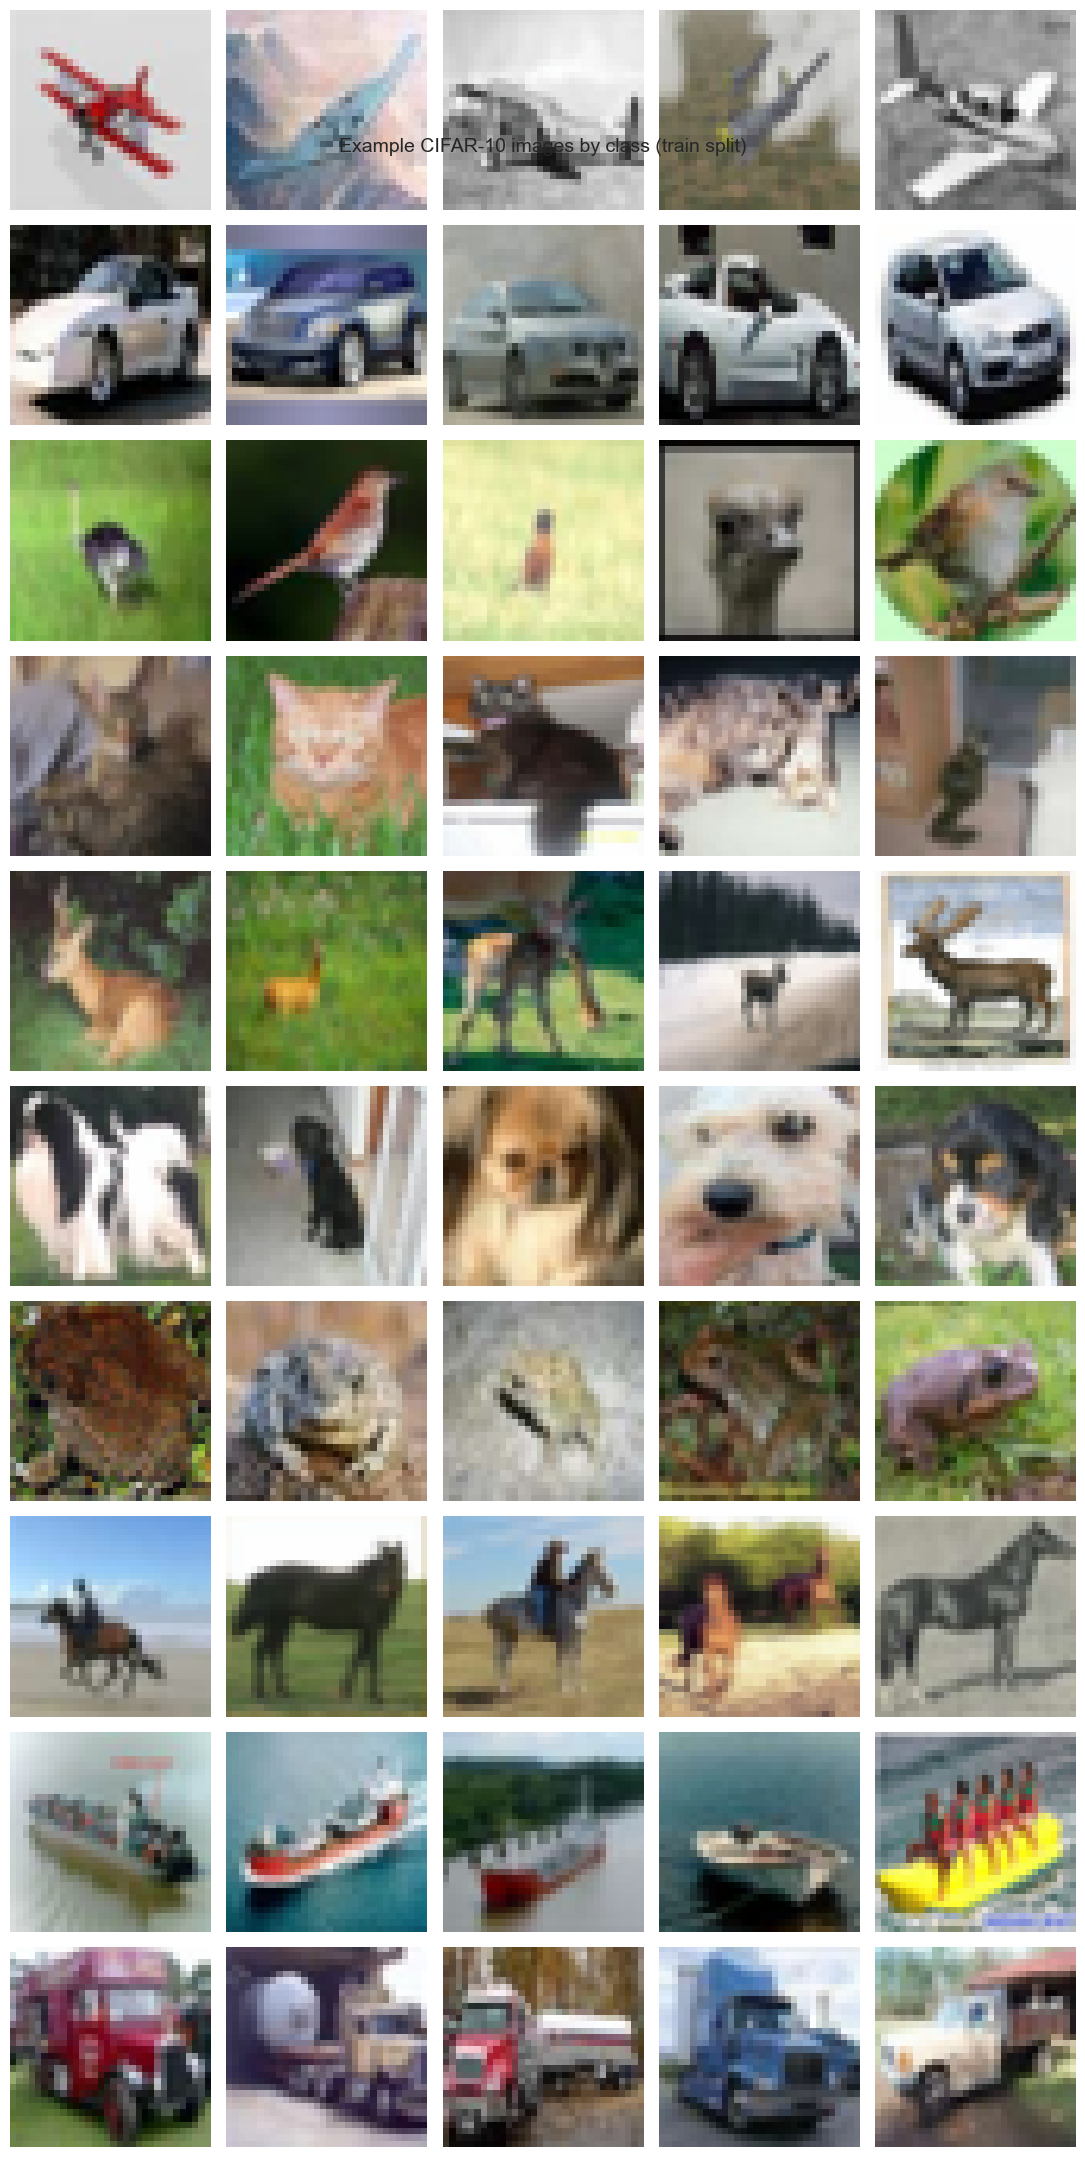

In [9]:
# Visualize example images from the training set

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])


def unnormalize(img):
    """Convert a normalized image tensor (3, 32, 32) back to [0, 1] RGB image for plotting."""
    img = img * std[:, None, None] + mean[:, None, None]
    img = np.clip(img, 0.0, 1.0)
    return np.transpose(img, (1, 2, 0))  # (H, W, C) for matplotlib


num_classes = len(class_names)
samples_per_class = 5

fig, axes = plt.subplots(
    num_classes,
    samples_per_class,
    figsize=(2.2 * samples_per_class, 2.2 * num_classes)
)

for class_idx, class_name in enumerate(class_names):
    class_indices = np.where(y_train == class_idx)[0]
    # In the unlikely event a class has fewer samples than requested, allow replacement
    replace = len(class_indices) < samples_per_class
    selected_indices = np.random.choice(
        class_indices, size=samples_per_class, replace=replace
    )

    for j, idx in enumerate(selected_indices):
        ax = axes[class_idx, j] if num_classes > 1 else axes[j]
        img = unnormalize(X_train_img[idx])
        ax.imshow(img)
        ax.axis("off")
        if j == 0:
            ax.set_ylabel(
                class_name,
                rotation=0,
                ha="right",
                va="center",
                fontsize=10,
            )

plt.suptitle("Example CIFAR-10 images by class (train split)", fontsize=14, y=0.92)
plt.tight_layout()
plt.show()



Running TSNE on 35000 training samples (out of 35000) ...
TSNE completed.


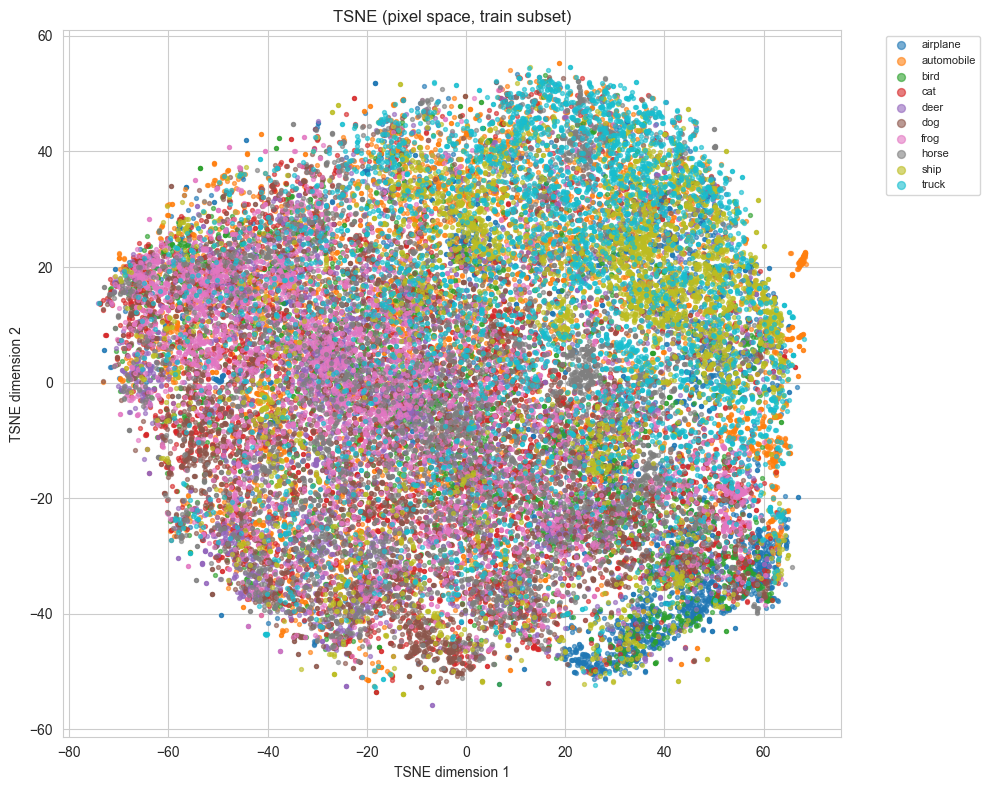

In [13]:
# TSNE visualization of CIFAR-10 in pixel space (subsampled from train set)

# To keep TSNE reasonably fast, we only use a random subset of the training data.
max_samples = 35_000
num_train = X_train.shape[0]

subset_size = min(max_samples, num_train)
subset_indices = np.random.choice(num_train, size=subset_size, replace=False)

X_subset = X_train[subset_indices]
y_subset = y_train[subset_indices]

print(f"Running TSNE on {subset_size} training samples (out of {num_train}) ...")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=SEED,
)
X_embedded = tsne.fit_transform(X_subset)

print("TSNE completed.")

# Plot the 2D embedding, colored by class
plt.figure(figsize=(10, 8))

palette = sns.color_palette("tab10", n_colors=len(class_names))
for class_idx, class_name in enumerate(class_names):
    mask = y_subset == class_idx
    plt.scatter(
        X_embedded[mask, 0],
        X_embedded[mask, 1],
        s=8,
        color=palette[class_idx],
        alpha=0.6,
        label=class_name,
    )

plt.title("TSNE (pixel space, train subset)")
plt.xlabel("TSNE dimension 1")
plt.ylabel("TSNE dimension 2")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



## Experiment 1: Model-wise Double Descent

Train 4 models of varying complexity for 100 epochs each.


In [ ]:
print("experiment 1: model-wise double descent")

model_wise_results = run_model_wise_experiment(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    num_epochs=CONFIG['model_wise']['num_epochs'],
    learning_rate=CONFIG['model_wise']['learning_rate'],
    results_dir=CONFIG['model_wise']['results_dir'],
    seed=SEED
)

#generate visualizations
plot_model_wise_double_descent(model_wise_results)
create_results_summary_table(model_wise_results)

#find and plot best model confusion matrix
best_model_name = max(model_wise_results.keys(), key=lambda k: model_wise_results[k]['test_f1'])
plot_confusion_matrix(
    y_test,
    model_wise_results[best_model_name]['y_pred'],
    class_names,
    save_path=f'report/figures/confusion_matrix_{best_model_name.lower().replace(" ", "_")}.pdf'
)

print(f"\nbest model: {best_model_name} with F1 = {model_wise_results[best_model_name]['test_f1']:.4f}")


## Experiment 2: Epoch-wise Double Descent

Train a single model for 400 epochs.


In [ ]:
print("experiment 2: epoch-wise DD")

epoch_wise_results = run_epoch_wise_experiment(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    model_name=CONFIG['epoch_wise']['model_name'],
    num_epochs=CONFIG['epoch_wise']['num_epochs'],
    learning_rate=CONFIG['epoch_wise']['learning_rate'],
    results_dir=CONFIG['epoch_wise']['results_dir'],
    seed=SEED
)

# Generate visualizations
plot_epoch_wise_double_descent(epoch_wise_results)

print(f"\nfinal F1 score: {epoch_wise_results['test_f1']:.4f}")


In [ ]:
print(f"all experiments completed at end time {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")